# TP - Computação Natural
#### "Predict whether a mammogram mass is benign or malignant"

1. BI-RADS assessment: 1 to 5 (ordinal)  
2. Age: patient's age in years (integer)
3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
6. Severity: benign=0 or malignant=1 (binominal)

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats

## Get the Data

In [4]:
data = pd.read_csv('mammographic_masses.data.txt')
data

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0
...,...,...,...,...,...,...
955,4,47,2,1,3,0
956,4,56,4,5,3,1
957,4,64,4,5,3,0
958,5,66,4,5,3,1


** Convert missing data (indicated by a ?) into NaN and add the appropriate column names (BI_RADS, age, shape, margin, density, and severity) **

In [5]:
data = data.replace('?',np.nan)
data.columns = ['BI_RADS','Age','Shape','Margin','Density','Severity']
data

,BI_RADS,Age,Shape,Margin,Density,Severity
0,4,43,1,1,NaN,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,NaN,1
4,4,65,1,NaN,3,0
...,...,...,...,...,...,...
955,4,47,2,1,3,0
956,4,56,4,5,3,1
957,4,64,4,5,3,0
958,5,66,4,5,3,1


** Drop BI_RADS column because it has no influence on the severity forecast **

In [7]:
data = data.drop(columns=['BI_RADS'])

KeyError: "['BI_RADS'] not found in axis"

** Convert datatype 'object' to 'float64' **  

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
Age         955 non-null object
Shape       929 non-null object
Margin      912 non-null object
Density     884 non-null object
Severity    960 non-null int64
dtypes: int64(1), object(4)
memory usage: 37.6+ KB


In [8]:
data = data.astype(float)
data

,Age,Shape,Margin,Density,Severity
0,43.0,1.0,1.0,NaN,1.0
1,58.0,4.0,5.0,3.0,1.0
2,28.0,1.0,1.0,3.0,0.0
3,74.0,1.0,5.0,NaN,1.0
4,65.0,1.0,NaN,3.0,0.0
...,...,...,...,...,...
955,47.0,2.0,1.0,3.0,0.0
956,56.0,4.0,5.0,3.0,1.0
957,64.0,4.0,5.0,3.0,0.0
958,66.0,4.0,5.0,3.0,1.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
Age         955 non-null object
Shape       929 non-null object
Margin      912 non-null object
Density     884 non-null object
Severity    960 non-null int64
dtypes: int64(1), object(4)
memory usage: 37.6+ KB


In [10]:
data.describe()

,Severity
count,960.000000
mean,0.462500
std,0.498852
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Analysing missing values
*First we get the missing values per feature.*
*Lets check them out as well*

In [11]:
missing_values_feature = data.isnull().sum(axis=0)
print(missing_values_feature)

Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64


<BarContainer object of 5 artists>

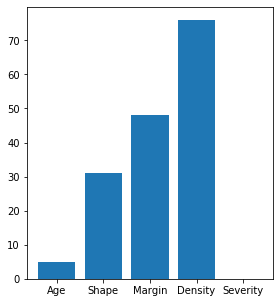

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.bar(missing_values_feature.axes[0].to_list(), missing_values_feature.values)

*We then develop a heatmap to give us some more information*

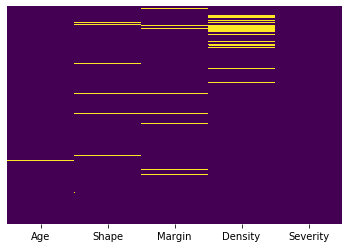

In [13]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

*Finally we can check the percentage of missing values per feature*

In [16]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
print(missing_value_df)

percent_missing
Age              0.520833
Shape            3.229167
Margin           5.000000
Density          7.916667
Severity         0.000000


**Now lets analyse the missing data per class (Severity = 0 or Severity = 1).**
*First we group the missing values per class*

In [18]:
grouped_data = data.groupby('Severity')
missing_values_class = grouped_data.count().rsub(grouped_data.size(), axis=0)
print(missing_values_class)

Age  Shape  Margin  Density
Severity                             
0           0     19      37       54
1           5     12      11       22


*Now we split the dataframe per class so we can draw our plot*

In [29]:
m_new_1, m_new_2 = missing_values_class.head(1), missing_values_class.tail(1)

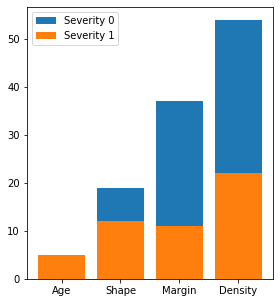

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.bar(m_new_1.axes[1].to_list(), m_new_1.values[0], label = "Severity 0")
plt.subplot(131)
plt.bar(m_new_2.axes[1].to_list(), m_new_2.values[0], label = "Severity 1")
plt.legend()

**Finally, for each class we're going to calculate the number of rows that have 1 and 2 NaN values**

In [34]:
rows_mv1_sv0 = 0
rows_mv2_sv0 = 0
rows_mv1_sv1 = 0
rows_mv2_sv1 = 0

In [35]:
for index, row in data.iterrows():
    if(row['Severity'] == 0):
        if(row.isnull().sum() == 1):
            rows_mv1_sv0 += 1
        elif(row.isnull().sum() == 2):
            rows_mv2_sv0 += 1
    else:
        if(row.isnull().sum() == 1):
            rows_mv1_sv1 += 1
        elif(row.isnull().sum() == 2):
            rows_mv2_sv1 += 1

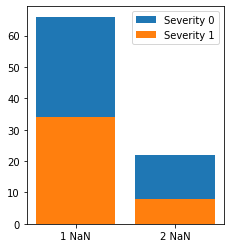

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.bar(['1 NaN', '2 NaN'], [rows_mv1_sv0,rows_mv2_sv0], label = "Severity 0")
plt.subplot(131)
plt.bar(['1 NaN', '2 NaN'], [rows_mv1_sv1,rows_mv2_sv1], label = "Severity 1")
plt.legend()

** The missing data seems randomly distributed, so we drop rows with missing data **

In [ ]:
data = data.dropna()
data.index = np.arange(1, len(data) + 1)
data

** !!! (Ou podemos meter os dados que faltavam, ver isto) !!! **

In [ ]:
data.describe()

## Exploratory Data Analysis

** Countplot of the Severity (Benign 0 vs Malignant 1) **

In [ ]:
sns.countplot(x='Severity',data=data)

** Histogram showing Age based on the Severity column **

In [ ]:
sns.set_style('darkgrid')
g = sns.FacetGrid(data,hue="Severity",palette='coolwarm',size=6,aspect=2)
g = (g.map(plt.hist,'Age',bins=20,alpha=0.7)).add_legend()

##### Detect outliers: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

### Detect Outliers using Box plot (Uni-variate outlier)

In [ ]:
sns.boxplot(x=data['Age'])

In [ ]:
sns.boxplot(x=data['Shape'])

In [ ]:
sns.boxplot(x=data['Margin'])

In [ ]:
sns.boxplot(x=data['Density'])

### Detect Outliers using Scatter plot (Multi-variate outlier)

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data['Age'], data['Shape'])
ax.set_xlabel('Age')
ax.set_ylabel('Shape')
#ax.set_ylabel('Margin')
#ax.set_ylabel('Density')
plt.show()

### Detect outliers using mathematical function Z-Score

In [ ]:
z = np.abs(stats.zscore(data))
threshold = 3
print(np.where(z > threshold))
# The first array contains the list of row numbers and second array respective column numbers

Column 3 (density) has all outliers

### Detect outliers using IQR Score
Similar to Z-Score

In [ ]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
iqr = Q3 - Q1
print(iqr)

In [ ]:
# Não curti ...
print(data < (Q1 - 1.5 * iqr)) |(data > (Q3 + 1.5 * iqr))

### Remove Outliers using Z-Score

##### + explanations: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

In [ ]:
# Só fazer 1 vez
data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
data.index = np.arange(1, len(data) + 1)
data

### Converting pandas dataframes to numpy arrays

In [ ]:
X_train = data.drop('Severity',axis=1).to_numpy()
y_train = data['Severity'].to_numpy()

### Normalizing the attribute data using StandardScaler

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.transform(X_train)

## Neural Networks